In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Environment

In [10]:
class BernoulliEnvironment():
    def __init__(self, p, T):
        self.K = len(p) # Number of arms
        self.t = 0 # Current round

        # generate (N° round, N° arms) rewards
        self.rewards = np.random.binomial(n=1, p=p, size=(T, self.K)) 

    def round(self, a_t):
        r_t = self.rewards[self.t, a_t]
        self.t +=1
        return r_t

# Agent

In [11]:
class UCB1Agent():
    def __init__(self, K, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t 
        else:
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

In [12]:
class ETCAgent():
    def __init__(self, K, T, T0):
        self.K = K 
        self.T = T
        self.T0 = T0
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t <= self.K*self.T0:
            self.a_t = self.t % self.K
        else:
            self.a_t = np.argmax(self.average_rewards)
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

In [23]:
class TSAgent():
    def __init__(self, K, prior=None):
        self.K = K
        self.a_t = None
        self.alpha, self.beta = (np.ones(K), np.ones(K)) if prior==None else prior
        # logging
        self.N_pulls = np.zeros(K)
        self.theta = []

    def pull_arm(self):
        theta = np.random.beta(self.alpha, self.beta)
        self.theta.append(theta)
        self.a_t = np.argmax(theta)
        return self.a_t
    
    def update(self, r_t):
        self.alpha[self.a_t] += r_t
        self.beta[self.a_t] += 1-r_t
        self.N_pulls[self.a_t] += 1

In [ ]:
def evaluate_agent(p, T, agent_init, n_trials, seed=42):
    # Find the best action (arm) - the one with the highest probability
    best_action = np.argmax(p)
    K = len(p)  # Number of arms

    # Expected rewards if always pulling the best arm
    expected_clairvoyant_rewards = np.repeat(p[best_action], T)

    regret_per_trial = []

    np.random.seed(seed)  # Set random seed for reproducibility
    for _ in range(n_trials):
        env = BernoulliEnvironment(p, T)  # Create environment
        agent = agent_init(K, T)          # Initialize agent

        agent_rewards = np.array([])      # Store agent's rewards

        for t in range(T):
            a_t = agent.pull_arm()        # Agent selects arm
            r_t = env.round(a_t)          # Environment returns reward
            agent.update(r_t)             # Agent updates its state

            agent_rewards = np.append(agent_rewards, r_t)  # Store reward

        # Calculate cumulative regret for this trial
        cumulative_regret = np.cumsum(expected_clairvoyant_rewards - agent_rewards)
        regret_per_trial.append(cumulative_regret)

    regret_per_trial = np.array(regret_per_trial)  # Convert to numpy array

    # Compute average and standard deviation of regret across trials
    avg_regret = regret_per_trial.mean(axis=0)
    regret_sd = regret_per_trial.std(axis=0)
    return avg_regret, regret_sd

In [19]:
def compare_agents(p, T, agent1_init, agent2_init, n_trials, seed=42):
    # Find the best action (arm) - the one with the highest probability
    best_action = np.argmax(p)
    K = len(p)  # Number of arms

    # Expected rewards if always pulling the best arm
    expected_clairvoyant_rewards = np.repeat(p[best_action], T)

    first_regret_per_trial = []  # Regret for agent 1 in each trial
    sec_regret_per_trial = []    # Regret for agent 2 in each trial

    np.random.seed(seed)  # Set random seed for reproducibility
    for _ in range(n_trials):
        state = np.random.get_state()  # Save RNG state

        # Run agent 1
        env = BernoulliEnvironment(p, T)  # Create environment
        agent1 = agent1_init(K, T)        # Initialize agent 1

        agent_rewards = np.array([])      # Store agent's rewards
        for t in range(T):
            a_t = agent1.pull_arm()       # Agent selects arm
            r_t = env.round(a_t)          # Environment returns reward
            agent1.update(r_t)            # Agent updates its state
            agent_rewards = np.append(agent_rewards, r_t)  # Store reward
        
        cumulative_regret = np.cumsum(expected_clairvoyant_rewards - agent_rewards)
        first_regret_per_trial.append(cumulative_regret)

        np.random.set_state(state)        # Restore RNG state for agent 2

        # Run agent 2
        env = BernoulliEnvironment(p, T)  # Create environment
        agent2 = agent2_init(K, T)        # Initialize agent 2

        agent_rewards = np.array([])      # Store agent's rewards
        for t in range(T):
            a_t = agent2.pull_arm()       # Agent selects arm
            r_t = env.round(a_t)          # Environment returns reward
            agent2.update(r_t)            # Agent updates its state
            agent_rewards = np.append(agent_rewards, r_t)  # Store reward

        cumulative_regret = np.cumsum(expected_clairvoyant_rewards - agent_rewards)
        sec_regret_per_trial.append(cumulative_regret)

    # Convert to numpy arrays for easier computation
    first_regret_per_trial = np.array(first_regret_per_trial)
    sec_regret_per_trial = np.array(sec_regret_per_trial)

    # Compute average and standard deviation of regret across trials
    first_avg_regret = first_regret_per_trial.mean(axis=0)
    first_regret_sd = first_regret_per_trial.std(axis=0)
    sec_avg_regret = sec_regret_per_trial.mean(axis=0)
    sec_regret_sd = sec_regret_per_trial.std(axis=0)
    return (first_avg_regret, first_regret_sd), (sec_avg_regret, sec_regret_sd)

# Interaction

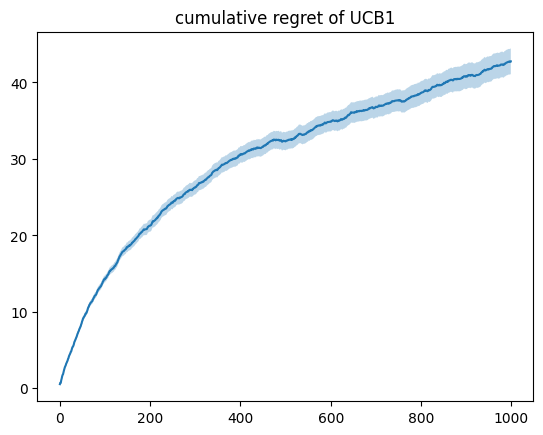

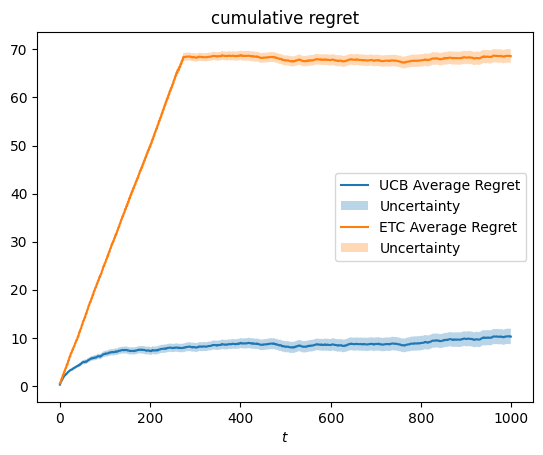

In [ ]:
p = np.array([0.25, 0.5, 0.75]) # True rewards of the arms
K = len(p) # Number of arms
T = 1000 # Number of rounds
seed = 17 # Set a seed for reproducibility
n_trials = 100 # Number of trials for averaging


## Evaluate UCB1 Agent
average_regret, regret_sd = evaluate_agent(p,T,lambda K,T: UCB1Agent(K,T), n_trials)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.show()


## Compare TSAgent and ETC agents
ucb_results, etc_results = compare_agents(p,T,
                                          lambda K,T : TSAgent(K), 
                                          lambda K,T : ETCAgent(K, T, (T/K)**(2/3)*np.log(T)**(1/3)),
                                          n_trials)
ucb_average_regret, ucb_regret_sd = ucb_results
etc_average_regret, etc_regret_sd = etc_results


plt.plot(np.arange(T), ucb_average_regret, label='UCB Average Regret')
plt.fill_between(np.arange(T),
                ucb_average_regret-ucb_regret_sd/np.sqrt(n_trials),
                ucb_average_regret+ucb_regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.plot(np.arange(T), etc_average_regret, label='ETC Average Regret')
plt.fill_between(np.arange(T),
                etc_average_regret-etc_regret_sd/np.sqrt(n_trials),
                etc_average_regret+etc_regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.title('cumulative regret')
plt.xlabel('$t$')
plt.legend()
plt.show()
